In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import os

BASE_PATH = "/kaggle/input"
print(tf.__version__)

2.1.0-rc0


### Train Fashion mnist model

In [2]:
(X_train, y_train), (X_val, y_val) = keras.datasets.fashion_mnist.load_data()
X_train.shape, y_train.shape, X_val.shape, y_val.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
rows = 28
cols = 28
input_shape = (rows*cols,)
X_train = X_train.reshape(len(X_train), rows*cols)
X_val = X_val.reshape(len(X_val), rows*cols)

In [5]:
def normalize_data(x, y, n_classes = 10):
    """
    function is normalize image data by dividing by 255
    & convert its label into one hot encoding
    
    Args
    --------
    x: array with batch of images
    y: corresponding labels of images (intergers)
    n_classes: number of classes
    
    Returns
    ---------
    tuple (normalized x, one-hot encoded y)
    
    """
    x = x/255.0
    y = tf.one_hot(y, depth=n_classes)
    return x, y

X_train, y_train = normalize_data(X_train, y_train)
X_val, y_val = normalize_data(X_val, y_val)

In [6]:
from tensorflow.keras import layers
num_classes = 10

fmnist_model = tf.keras.Sequential([
    layers.Dense(1000, input_shape=input_shape),
    layers.Dense(1000, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(200, activation='relu'),
    layers.Dense(num_classes, activation='softmax')])

In [9]:
from tensorflow.keras.callbacks import *

# to log results
csv_logger = CSVLogger('training_results.csv')

# model checkpoint
WORK_PATH = "/kaggle/working"
ORG_WEIGHTS = os.path.join(WORK_PATH, 'original.h5')
checkpoint = ModelCheckpoint(ORG_WEIGHTS, monitor='val_loss', verbose = 0,
                             save_best_only=1,mode='min')

# early_stopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-2, 
              patience=5, mode='auto',restore_best_weights=1)

# reduce LR on plateau
lr_reduce = ReduceLROnPlateau(monitor='val_loss', mode='min', verbose = 0,
                               factor = 0.5, patience = 3, min_lr = 1e-5)

# compile the model
fmnist_model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
# fit the model
history = fmnist_model.fit(X_train, y_train,batch_size = 32, epochs = 20,
                 validation_data=(X_val, y_val), callbacks = [checkpoint, lr_reduce, 
                                                              early_stop, csv_logger])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 32s 541us/sample - loss: 0.5592 - accuracy: 0.8007 - val_loss: 0.5289 - val_accuracy: 0.8170
Epoch 2/20
60000/60000 [==============================] - 32s 535us/sample - loss: 0.4490 - accuracy: 0.8397 - val_loss: 0.4144 - val_accuracy: 0.8524
Epoch 3/20
60000/60000 [==============================] - 32s 531us/sample - loss: 0.4188 - accuracy: 0.8520 - val_loss: 0.4421 - val_accuracy: 0.8402
Epoch 4/20
60000/60000 [==============================] - 31s 520us/sample - loss: 0.3992 - accuracy: 0.8569 - val_loss: 0.4729 - val_accuracy: 0.8282
Epoch 5/20
60000/60000 [==============================] - 32s 531us/sample - loss: 0.3849 - accuracy: 0.8628 - val_loss: 0.4855 - val_accuracy: 0.8391
Epoch 6/20
60000/60000 [==============================] - 31s 524us/sample - loss: 0.3257 - accuracy: 0.8807 - val_loss: 0.3496 - val_accuracy: 0.8717
Epoch 7/20
60000/60000 [====================

In [ ]:
# tf.keras.models.save_model(fmnist_model, ORG_WEIGHTS)

### Pruning Starts Here

In [17]:
def weight_pruning(w, s):
    
    """
    Ranks & Prunes the least absoulte (s%) values in given weight matrix

    Args
    -------
    w: weight matrix
    s: Sparsity level in range(0,1).  
    
    Returns
    -------
    modified weight matrix (w) with given sparsity
    """
    
    w = np.array(w)
    # ranks from lowest to highest
    ranks = rankdata(np.abs(w),method='dense') 
    # find the theshold for given sparsity
    threshold = np.ceil(ranks.max() * s).astype(int)
    # create mask to multuiply
    mask = ranks.reshape(w.shape)
    # set the elements in the mask
    mask[mask <= threshold] = 0
    mask[mask > threshold] = 1
    # multiply the originalweights with mask to get sparse weights
    return w*mask

def neuron_pruning(w, s):
    
    """
    Ranks & Prunes the least L2 norm (s%) columns for a given weight matrix

    Args
    -------
    w: weight matrix
    s: Sparsity level in range(0,1).  
    
    Returns
    -------
    modified weight matrix (w) with given sparsity
    """
    
    w = np.array(w)
    # calculate the L2 norm
    norm = np.sqrt(np.sum(w*w, axis=0))
    # ranks from lowest to highest
    ranks = rankdata(norm,method='dense') 
    # find the threshold for given sparsity
    threshold = np.ceil(ranks.max() * s).astype(int)
    # find the indices of columns below threshold
    zero_col_indices = np.where(ranks <= threshold)[0]
    # set the entire columns to zero
    w[:,zero_col_indices] = 0
    
    return w


def model_pruning(file, s = .25, pruning_type = 'weight_pruning'):
    
    """
    Purnes All weights (except last\output layer) with given purning type for a given model(.h5) file

    Args
    -------
    file: keras model file (.h5).
    s: Sparsity level in range(0,1).  
    pruning_type: choose b/w ('weight_pruning','neuron_pruning')
    
    Returns
    -------
    modified model file (.h5) with given sparsity
    """
    
    for layer in list(file['model_weights'].keys())[:-1]:
        if not layer.startswith('dropout'):
            # get only main weights, ignore bias
            W = file['model_weights'][layer][layer]['kernel:0']
            # choose the purning type
            if pruning_type == 'weight_pruning':
                W[...] = weight_pruning(W, s = s)
            elif pruning_type == 'neuron_pruning':
                W[...] = neuron_pruning(W, s = s)
            # assert the changes
            assert(W == file['model_weights'][layer][layer]['kernel:0'])        
    return file

### Create Pruned models with different sparsities

In [21]:
import shutil
import h5py
from scipy.stats import rankdata

SW_PATH = {}
for d in ['weight_pruning', 'neuron_pruning']:
    dir_path = os.path.join(WORK_PATH, d)
    SW_PATH[d] = dir_path
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

sparsity_levels =  [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

# with h5py.File(ORG_WEIGHTS,'r+') as f:

for s in sparsity_levels:
    sw_path = os.path.join(SW_PATH['weight_pruning'], "wp_{}.h5".format(s))
    shutil.copyfile(ORG_WEIGHTS, sw_path)
    f_sparse = h5py.File(sw_path, "r+")
    f_sparse = model_pruning(f_sparse, s = s/100, pruning_type = 'weight_pruning')
    f_sparse.close()
    
    
for s in sparsity_levels:
    sw_path = os.path.join(SW_PATH['neuron_pruning'], "np_{}.h5".format(s))
    shutil.copyfile(ORG_WEIGHTS, sw_path)
    f_sparse = h5py.File(sw_path, "r+")
    f_sparse = model_pruning(f_sparse, s = s/100, pruning_type = 'neuron_pruning')
    f_sparse.close()

### Evalaute the sparse weights

In [22]:
from pathlib import Path

# get the files with their paths & sort them
wp_files = sorted(Path(SW_PATH['weight_pruning']).rglob("wp*.h5"))
np_files = sorted(Path(SW_PATH['neuron_pruning']).rglob("np*.h5"))

# create a dataframe to store the results
results_df = pd.DataFrame(data = sparsity_levels, columns = ['sparsity'])
results_df['weight_pruning_acc'] = None
results_df['neuron_pruning_acc'] = None

# loop throught the sparse weight files & evalaute on them
for i, f in enumerate(wp_files):
    restored_model = tf.keras.models.load_model(f)
    score = restored_model.evaluate(X_val, y_val, verbose=0)
    results_df.loc[i, 'weight_pruning_acc'] = score[1]*100


for i, f in enumerate(np_files):
    restored_model = tf.keras.models.load_model(f)
    score = restored_model.evaluate(X_val, y_val, verbose=0)
    results_df.loc[i, 'neuron_pruning_acc'] = score[1]*100

### Plot the results

Text(0.5, 0, 'sparsity %')

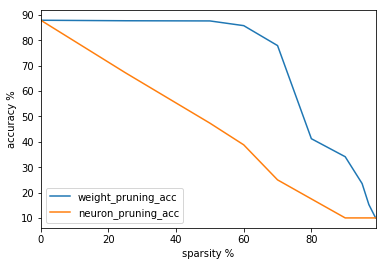

In [23]:
import matplotlib.pyplot as plt

# modify the index (it will be used as x-axis) & plot
rx = results_df.set_index('sparsity').plot(figsize=(6,4))

# set x & y axis labels
rx.set_ylabel('accuracy %')
rx.set_xlabel('sparsity %')

In [25]:
# KerasModelPruner test
# from tf_keras_pruning import KerasModelPurner
# kp = KerasModelPurner(sparsity = 0.3, pruning_type = 'weight_pruning')
# sw_path = os.path.join("wp_{}.h5".format(0.3))
# shutil.copyfile(ORG_WEIGHTS, sw_path)
# fs = h5py.File(sw_path, "r+")
# fs = kp.transform(fs)